In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
import open_clip
import json
import copy
from sklearn.model_selection import KFold
import bcolz
from torch.utils.data import DataLoader, TensorDataset

from urllib.request import urlopen

from open_clip import create_model_from_pretrained, get_tokenizer 
import torch.nn.functional as F


/home/csgrad/byalavar/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_of_interest = ['vertebrae_C1','vertebrae_C2','vertebrae_C3','vertebrae_C4','vertebrae_C5','vertebrae_C6','vertebrae_C7','vertebrae_L1','vertebrae_L2','vertebrae_L3',
                     'vertebrae_L4','vertebrae_L5','vertebrae_T1','vertebrae_T2','vertebrae_T3','vertebrae_T4','vertebrae_T5','vertebrae_T6','vertebrae_T7','vertebrae_T8',
                     'vertebrae_T9','vertebrae_T10','vertebrae_T11','vertebrae_T12']

CLASS_IND = {
    'spleen': 1,
    'kidney_right': 2,
    'kidney_left': 3,
    'gall_bladder': 4,
    'esophagus': 5,
    'liver': 6,
    'stomach': 7,
    'aorta': 8,
    'postcava': 9,
    'portal and splenic vein': 10,
    'pancreas': 11,
    'adrenal gland R': 12,
    'adrenal gland L': 13,
    'duodenum': 14,
    'hepatic vessel': 15,
    'lung R': 16,
    'lung L': 17,
    'colon': 18,
    'intestine': 19,
    'rectum': 20,
    'bladder': 21,
    'prostate': 22,
    'head of femur L': 23,
    'head of femur R': 24,
    'celiac trunk': 25,
    'kidney tumor': 26,
    'liver tumor': 27,
    'pancreatic tumor': 28,
    'hepatic vessel tumor': 29,
    'lung tumor': 30,
    'colon tumor': 31,
    'kidney cyst': 32,
}

# Create a new dictionary where keys from CLASS_IND are replaced with keys from class_of_interest
new_CLASS_IND = {key: CLASS_IND[value] for key, value in zip(class_of_interest, CLASS_IND.keys())}

print(new_CLASS_IND)

{'vertebrae_C1': 1, 'vertebrae_C2': 2, 'vertebrae_C3': 3, 'vertebrae_C4': 4, 'vertebrae_C5': 5, 'vertebrae_C6': 6, 'vertebrae_C7': 7, 'vertebrae_L1': 8, 'vertebrae_L2': 9, 'vertebrae_L3': 10, 'vertebrae_L4': 11, 'vertebrae_L5': 12, 'vertebrae_T1': 13, 'vertebrae_T2': 14, 'vertebrae_T3': 15, 'vertebrae_T4': 16, 'vertebrae_T5': 17, 'vertebrae_T6': 18, 'vertebrae_T7': 19, 'vertebrae_T8': 20, 'vertebrae_T9': 21, 'vertebrae_T10': 22, 'vertebrae_T11': 23, 'vertebrae_T12': 24}


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-laion2B-s32B-b82K')
model.to(device)
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-L-14-laion2B-s32B-b82K')
textTokens = torch.load("/home/csgrad/byalavar/XAI/AdaFace/conceptTokensExp2.pt")

In [4]:
concepts = ["Face of a Young Person","Face of a middle aged person","Face of a Old Person",
"Face of a Male","Face of a Female", #4
"Face color: Pale White","Face color: White", "Face color: Olive", "Face color: Moderate Brown", "Face color: Dark Brown","Face color: Black",#10
"Face shape: Oval","Face shape: Round","Face shape: Square","Face shape: Diamond","Face shape: Heart","Face shape: Pear","Face shape: Oblong",
"Approximate width of nose relative to eye distance: Similar", "Approximate width of nose relative to eye distance: Wider","Approximate width of nose relative to eye distance: Narrower",
"Proportions of features on face: Equal", "Proportions of features on face: Narrow", "Proportions of features on face: Wide", 
"Hair Length: Chin Length", "Hair Length: Neck Length", "Hair Length: Shoulder Length", "Hair Length: Collarbone Length","Hair Length: Long Length", 
"Hair Color: Black", "Hair Color: Blonde","Hair Color: Brown", 
"Forehead hairline: Symmetrical", "Forehead hairline: Widows peak", "Forehead hairline: Part line","Forehead hairline: Cowlick","Forehead hairline: Bald", 
"Hair Baldness Pattern: Receding Hairline","Baldness Pattern: Thinning Crown", " Hair Baldness Pattern: Vertex Baldness"," Hair Baldness Pattern: None", 
"Forehead height: Long","Forehead height: Normal", "Forehead height: Short", 
"Forehead width: Wide","Forehead width: Normal", "Forehead width: Narrow", 
"Brow ridges are Prominent", "Brow ridges are Subtle", 
"Right eyebrow shape is Arch", "Right eyebrow shape is Straight", "Right eyebrow shape is Curved", 
"Left eyebrow shape is Arch", "Left eyebrow shape is Straight", "Left eyebrow shape is Curved", 
"Left and Right Eyebrows: Symmetrical", "Left and Right Eyebrows: slighlty Asymmetrical", "Left and Right Eyebrows: significantly Asymmetrical", 
"Distance between eyes: Long", "Distance between eyes: Normal", "Distance between eyes: Short", 
"Eye Color: Amber","Eye Color: Blue","Eye Color: Brown","Eye Color: Gray","Eye Color: Green","Eye Color: Hazel","Eye Color: Red", 
"Left and Right Eyes: Symmetrical", "Left and Right Eyes: Slighlty Asymmetrical","Left and Right Eyes: Significantly Asymmetrical", 
"Right Cheekbone is prominent", "Right Cheekbone is not prominent", 
"Left Cheekbone is prominent", "Left Cheekbone is not prominent", 
"Dimple is present in the Left Cheek", "No Dimple is present in the Left Cheek", 
"Dimple is present in the Right Cheek", "No Dimple is present in the Right Cheek", 
"Nasal body: Straight", "Nasal body: Concave", "Nasal body: Convex", 
"Nasal tip: Pointed", "Nasal tip: Rounded", "Nasal tip: Upturned", "Nasal tip: Downturned", 
"Nasal base: Narrow", "Nasal base: Wide", 
"Mouth abnormalities: Absent", "Mouth abnormalities: Present", 
"Laryngeal prominence (Adam's apple) is Prominent", "Laryngeal prominence (Adam's apple) is Subtle", 
"Facial hair on neck, below chin/jawline is Present", "Facial hair on neck, below chin/jawline is Absent", 
"Frontal lines (forehead wrinkles) is Present", "Frontal lines (forehead wrinkles) is Absent", 
"Scars is Present", "Scars is Absent", 
"Skin marks is Present", "Skin marks is Absent", 
"Piercing is Present", "Piercing is Absent", 
"Makeup is Present", "Makeup is Absent",
"Tattoo is Present", "Tattoo is Absent"]

conceptTokens = tokenizer(concepts)



In [4]:
conceptTokens.shape

torch.Size([106, 77])

In [5]:
def read_memmap(mem_file_name):
    # r+ mode: Open existing file for reading and writing
    with open(mem_file_name+'.conf', 'r') as file:
        memmap_configs = json.load(file)
        return np.memmap(mem_file_name, mode='r+', \
                         shape=tuple(memmap_configs['shape']), \
                         dtype=memmap_configs['dtype'])


def imshow(img1, img2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=400)  # Create a figure with two subplots
    
    # Plot the first image
    img_array1 = img1[[0, 1, 2], :, :].transpose((1, 2, 0))
    axes[0].imshow(img_array1)
    axes[0].axis('off')  # Turn off axis
    
    # Plot the second image
    img_array2 = img2[[0, 1, 2], :, :].transpose((1, 2, 0))
    axes[1].imshow(img_array2)
    axes[1].axis('off')  # Turn off axis
    
    plt.show()


def getTopKSimilarConcepts(conceptScores,k):

    tensor1 =  conceptScores[0]
    tensor2 =  conceptScores[1]

    abs_diff = torch.abs(tensor1 - tensor2)


    top_indices = torch.topk(abs_diff, k=k, largest=False).indices
    
    for i in top_indices:
        print(concepts[i],conceptScores[0][i].item(),conceptScores[1][i].item(),abs_diff[i].item())

    #return concepts[top_indices]

def getTopKSimilarConcepts1(conceptScores,k):

    tensor1 =  conceptScores[0]
    tensor2 =  conceptScores[1]

    indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")
    
    #print(indices)
    subtensors1 = []
    for i in range(len(indices) - 1):
                start_idx = indices[i]
                end_idx = indices[i + 1]
                subtensor = tensor1[start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

                subtensors1.append(subtensor)

    last_start_idx = indices[-1]
    last_subtensor = tensor1[last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
    subtensors1.append(last_subtensor)

    subtensors2 = []
    for i in range(len(indices) - 1):
                start_idx = indices[i]
                end_idx = indices[i + 1]
                subtensor = tensor2[start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

                subtensors2.append(subtensor)

    last_start_idx = indices[-1]
    last_subtensor = tensor2[last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
    subtensors2.append(last_subtensor)

    #print(subtensors1)
    
    maxList1 = []
    for i in subtensors1:
        #print(i)
        maxList1.append(torch.argmax(i).item())

    maxList2 = []
    for i in subtensors2:
        #print(i)
        maxList2.append(torch.argmax(i).item())

    commonActivate = []
    for i in range(0,len(maxList1)):
        if(maxList1[i]==maxList2[i]):
            commonActivate.append(i)
    #print("st1: ",subtensors1)
    #print("ml1: ",maxList1)
    #print("st2: ",subtensors2)
    #print("ml2: ",maxList2)
    #print("commonActivate: ",commonActivate)

    topKSimilarIndices = []
    topKMin = []


    for i in commonActivate:
        #print(subtensors1[i][maxList1[i]],[maxList1[i]])
        diff = abs(subtensors1[i][maxList1[i]] - subtensors2[i][maxList2[i]])
        topKMin.append(diff.item())
        topKSimilarIndices.append((indices[i]+maxList1[i]).item())
        

    #print("topKMin: ",topKMin)
    #print("topKSimilarIndices: ",topKSimilarIndices)

    zipped_lists = zip(topKMin, topKSimilarIndices)

# Sort based on the first list
    sorted_zipped_lists = sorted(zipped_lists, key=lambda x: x[0])

# Unzip the sorted lists
    topKMin, topKSimilarIndices = zip(*sorted_zipped_lists)

    for i in range(0,len(topKSimilarIndices)):
        print(concepts[topKSimilarIndices[i]],topKMin[i])
        if(i>k):
            break


    



In [6]:
indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")

In [7]:
#init
#imgs = read_memmap("/data/bharat/XAI/faces_webface_112x112/cplfw/memfile/mem_file.dat")
ckpt = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/experiments/model2/epoch=3-step=45492.ckpt")
model.visual.load_state_dict({key.replace('model.visual.', ''):val
                                        for key,val in ckpt['state_dict'].items() if 'model.visual' in key})

conceptTokens = textTokens
fc = torch.nn.Linear(conceptTokens.shape[0],512).to(device)  
fc.weight = nn.Parameter(ckpt['state_dict']['fc.weight'])
fc.bias = nn.Parameter(ckpt['state_dict']['fc.bias'])

fcImage = nn.Sequential(
            nn.Linear(768, 768 // 2, bias=False),
            nn.ReLU(inplace=True),
        
            nn.Linear(768 // 2, 768, bias=False),
            nn.ReLU(inplace=True)
         )

fcImage[0].weight = nn.Parameter(ckpt['state_dict']['fcImage.0.weight'])
fcImage[2].weight = nn.Parameter(ckpt['state_dict']['fcImage.2.weight'])




conceptTokens = conceptTokens.to(device)
textFeatures = model.encode_text(conceptTokens)
normsT = torch.norm(textFeatures, 2, 1, True)
textFeatures = torch.div(textFeatures, normsT)
logit_scale = model.logit_scale
textFeatures  *= logit_scale.exp()
#textFeatures = nn.Parameter(textFeatures,requires_grad = False)
#textFeatures = ckpt['state_dict']['textFeatures'].to(device)

In [8]:
def get_val_data(data_path):
    agedb_30, agedb_30_issame = get_val_pair(data_path, 'agedb_30')
    cfp_fp, cfp_fp_issame = get_val_pair(data_path, 'cfp_fp')
    lfw, lfw_issame = get_val_pair(data_path, 'lfw')
    cplfw, cplfw_issame = get_val_pair(data_path, 'cplfw')
    calfw, calfw_issame = get_val_pair(data_path, 'calfw')
    return agedb_30, cfp_fp, lfw, agedb_30_issame, cfp_fp_issame, lfw_issame, cplfw, cplfw_issame, calfw, calfw_issame

def get_val_pair(path, name, use_memfile=True):
    if use_memfile:
        mem_file_dir = os.path.join(path, name, 'memfile')
        mem_file_name = os.path.join(mem_file_dir, 'mem_file.dat')
        if os.path.isdir(mem_file_dir):
            print('laoding validation data memfile')
            np_array = read_memmap(mem_file_name)
        else:
            os.makedirs(mem_file_dir)
            carray = bcolz.carray(rootdir = os.path.join(path, name), mode='r')
            np_array = np.array(carray)
            mem_array = make_memmap(mem_file_name, np_array)
            del np_array, mem_array 
            np_array = read_memmap(mem_file_name)
    else:
        np_array = bcolz.carray(rootdir = os.path.join(path, name), mode='r')

    issame = np.load(os.path.join(path, '{}_list.npy'.format(name)))
    return np_array, issame

In [9]:
age_30, cfp_fp, lfw, age_30_issame, cfp_fp_issame, lfw_issame, cplfw, cplfw_issame, calfw, calfw_issame = get_val_data("/data/bharat/XAI/faces_webface_112x112/")

laoding validation data memfile
laoding validation data memfile
laoding validation data memfile
laoding validation data memfile
laoding validation data memfile


In [10]:
model.eval()
fcImage.eval()
model = model.half()
fcImage = fcImage.half()


In [15]:
# valDatasetCPLFW = TensorDataset(images)

# dataloader = DataLoader(valDatasetCPLFW, batch_size=64, shuffle=False)
# model = model.half()
# fcImage = fcImage.half()


In [16]:
#     #Forward

#     #images = torch.tensor(cplfw)

# csNoSM = None
# finalOuts = None #Final Embeddings

# optimizer = torch.optim.Adam(model.parameters(),lr=0.1)


# for i,data in enumerate(dataloader):
#   optimizer.zero_grad()
#   embeddings = model.encode_image(data[0])
#   norms = torch.norm(embeddings, 2, 1, True)
#   embeddings = torch.div(embeddings, norms)

#     # #normsT = torch.norm(textFeatures,2,1,True)
#     # #textFeatures = torch.div(textFeatures, normsT)
#     # #conceptScores = textFeatures@embeddings.T

#   ratio = 0.2

#     # embeddings = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/imageTensorsVal.pt")
#     # labels = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/imageLabelsVal.pt")

  

#   embeddingsFC = fcImage(embeddings)



#   embeddings = ratio * embeddingsFC + (1 - ratio) * embeddings

#   print(textFeatures.shape)
#   textFeaturesTemp = textFeatures.unsqueeze(1)
#   print(textFeaturesTemp.shape)
#   conceptScores = torch.nn.functional.cosine_similarity(textFeaturesTemp,embeddings,dim=-1)
#   conceptScores = conceptScores.T
#   if(csNoSM==None):

#         csNoSM = copy.deepcopy(conceptScores.detach())
#   else:
#         csNoSM = torch.cat((csNoSM,copy.deepcopy(conceptScores.detach())),dim=0)       
#   indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")
#   subtensors = []
#   for i in range(len(indices) - 1):
#                     start_idx = indices[i]
#                     end_idx = indices[i + 1]
#                     subtensor = conceptScores[:,start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

#                     subtensors.append(subtensor)

#   last_start_idx = indices[-1]
#   last_subtensor = conceptScores[:,last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
#   subtensors.append(last_subtensor)

#   conceptScores = torch.cat([torch.nn.functional.softmax(100*subtensor, dim=-1) for subtensor in subtensors], dim=-1)

#     #print(conceptScores.shape)

#   output = fc(conceptScores)
#   if(finalOuts==None):

#         finalOuts = output
#   else:
#         finalOuts = torch.cat((finalOuts,output),dim=0) 
#     # norms = torch.norm(embeddings, 2, 1, True)
#     # embeddings = torch.div(embeddings, norms)






In [11]:
def imshow(img1, img2,normalize=False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=400)  # Create a figure with two subplots
    if(normalize):
    # Denormalize and plot the first image
     img1[0] = img1[0]*0.26862954 + 0.48145466
     img1[1] = img1[1]*0.26130258 + 0.4578275
     img1[2] = img1[2]*0.27577711 + 0.40821073

    img_array1 = img1  # Reverse normalization
    img_array1 = img_array1.transpose((1, 2, 0))
    axes[0].imshow(img_array1)
    axes[0].axis('off')  # Turn off axis

    # Denormalize and plot the second image
    if(normalize):
     img2[0] = img2[0]*0.26862954 + 0.48145466
     img2[1] = img2[1]*0.26130258 + 0.4578275
     img2[2] = img2[2]*0.27577711 + 0.40821073

    img_array2 = img2   # Reverse normalization
    img_array2 = img_array2.transpose((1, 2, 0))
    axes[1].imshow(img_array2)
    axes[1].axis('off')  # Turn off axis

    plt.show()

In [13]:
df = pd.read_csv("/data/bharat/IJB_C/labels.csv")

In [60]:
column_name = 'SUBJECT_ID'


value_to_find = 27970

# Find rows where the specified column has the value 'a'
rows_with_value_a = df[df[column_name] == value_to_find]

# Print the rows where the column value is 'a'
print(rows_with_value_a)

       TEMPLATE_ID  SUBJECT_ID  AGE  SKIN_COLOUR  GENDER  HEAD_POSE  SOURCE  \
3           108823       27970    0            0       1          1       1   
8971        108815       27970    0            0       1          1       1   
11951       108810       27970    0            0       1          1       1   
14852       108819       27970    0            0       1          0       1   
15062       108828       27970    0            0       1          1       1   
25717       108829       27970    0            0       1          0       0   
36700       108809       27970    0            0       1          1       1   
36753       108814       27970    0            0       1          0       1   
36838       108813       27970    0            0       1          1       1   
38918       108808       27970    0            0       1          1       1   
51937       108826       27970    0            0       1          0       1   
52690       108824       27970    0            0    

In [12]:
a = lfw[0::2]
b = lfw[1::2]

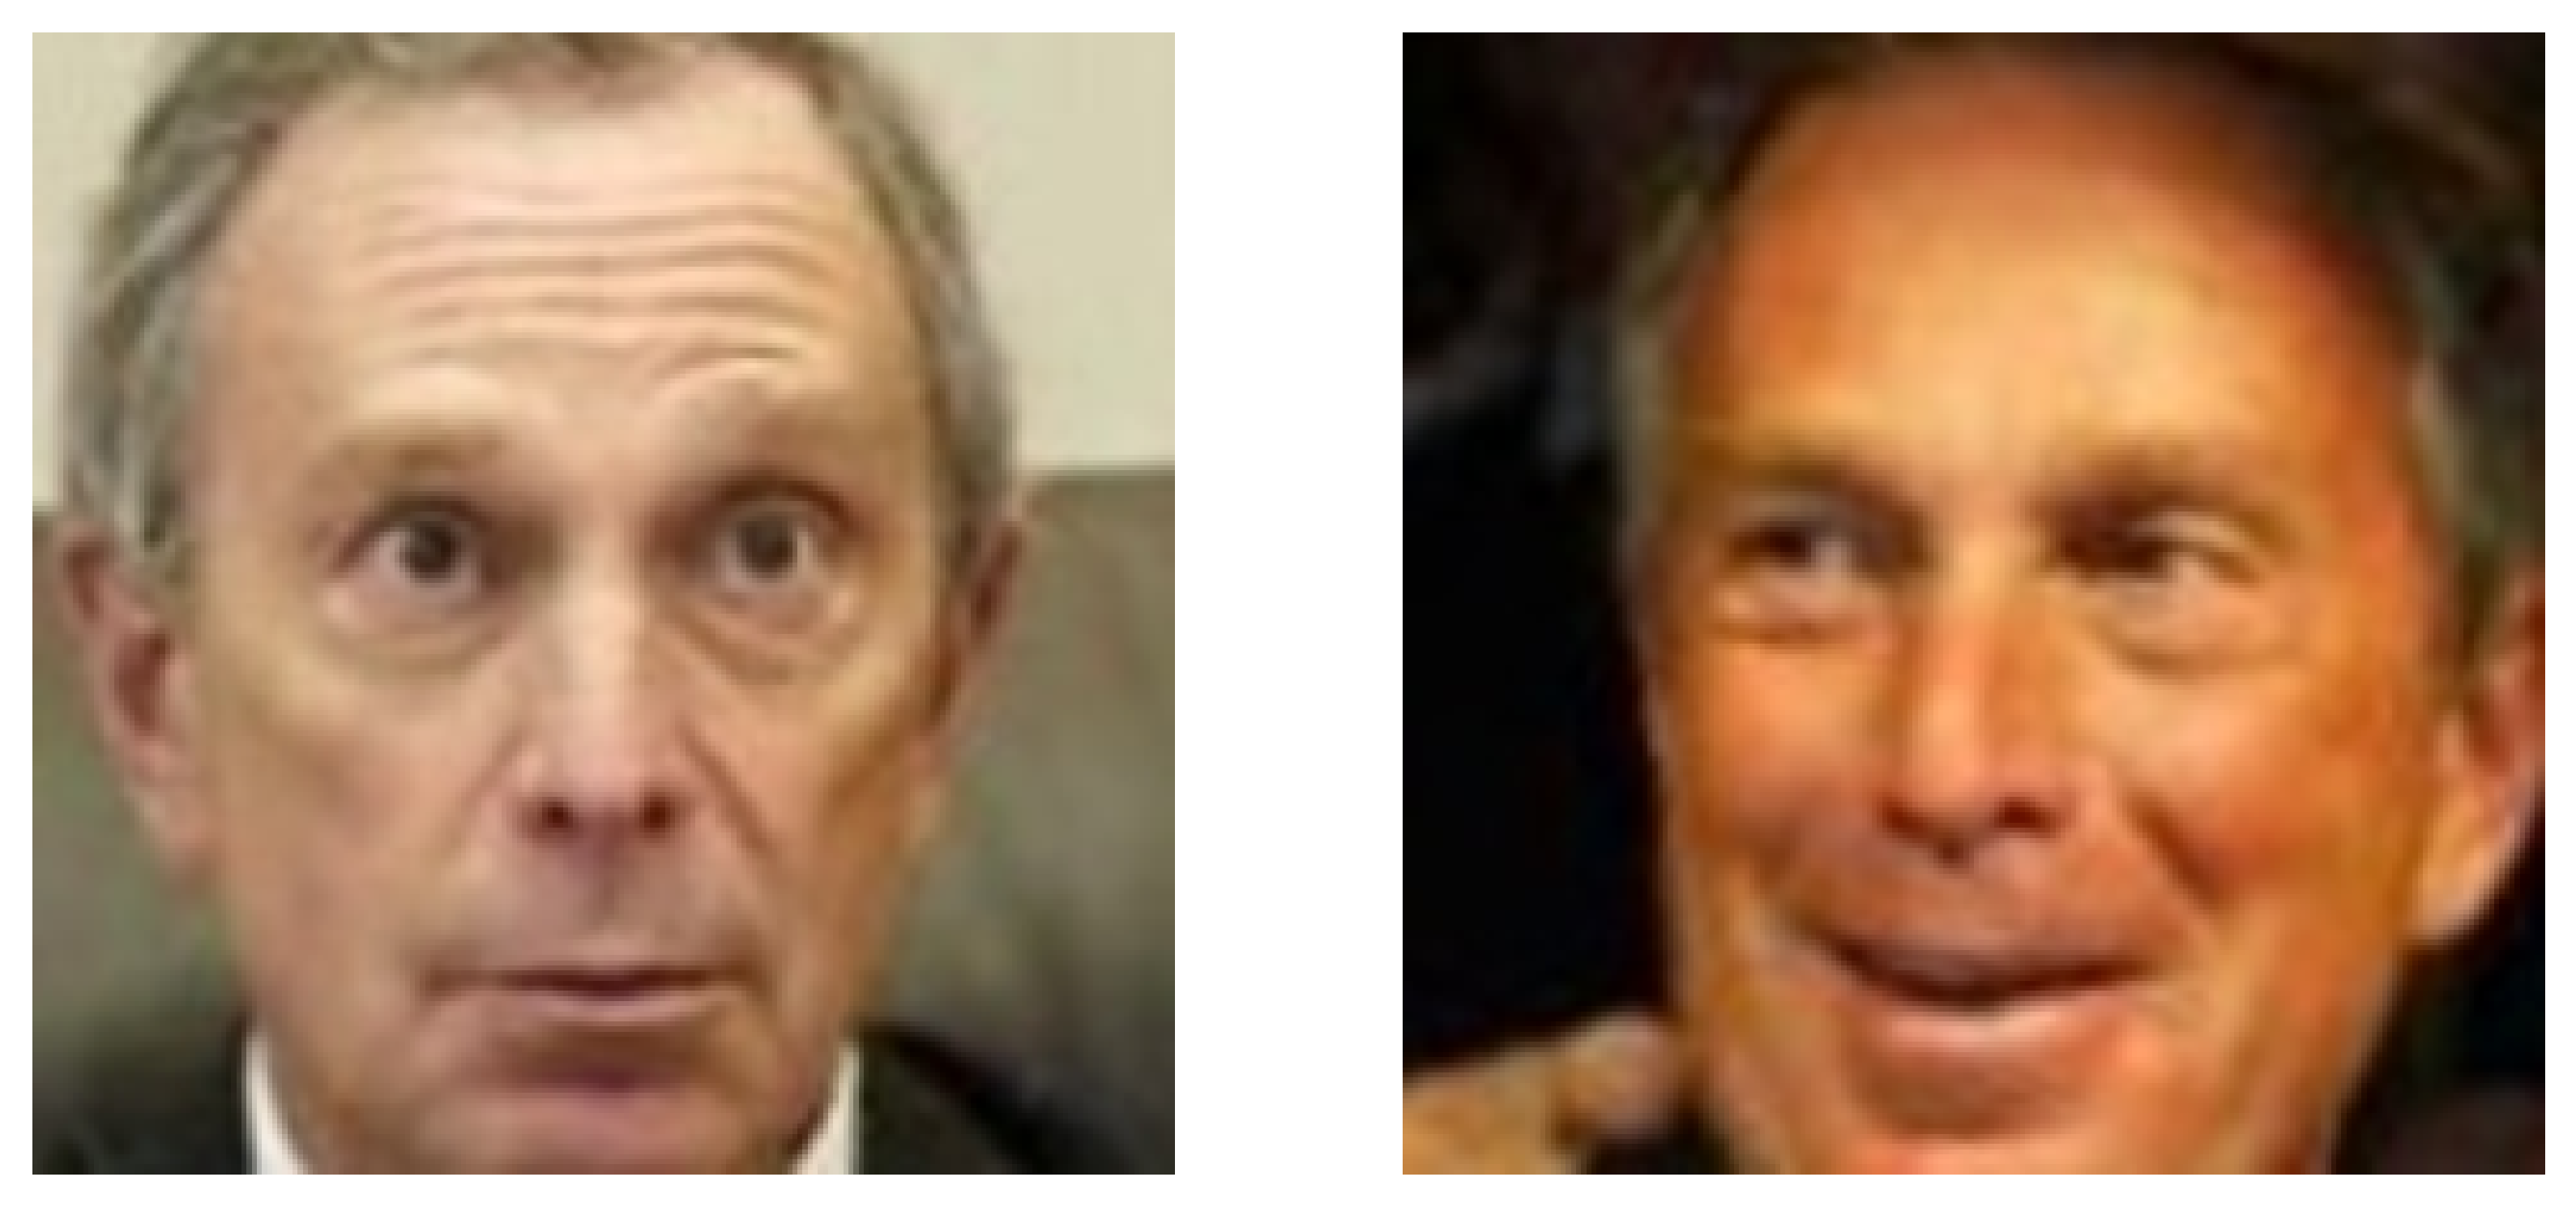

True


In [13]:
# 5619 True
# 5621 True
# 5637 True
# 5643 True
# 5655 True

index = 5619
imshow(np.array(a[index]),np.array(b[index]),normalize=True)
print(lfw_issame[index])

In [61]:
image1 = Image.open("/data/bharat/IJB_C/data/108815.jpg")
image2 = Image.open("/data/bharat/IJB_C/data/108823.jpg")

image1 = image1.convert("RGB")
image2 = image2.convert("RGB")

# Define additional transformations
additional_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 256x256
    transforms.ToTensor(),
    #transforms.RandomCrop(224),     # Randomly crop a 224x224 region
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue randomly
])

print(image1)
# Apply the additional transformations
img1 = additional_transforms(image1)
img2 = additional_transforms(image2)

<PIL.Image.Image image mode=RGB size=198x200 at 0x7FCD9C284C40>


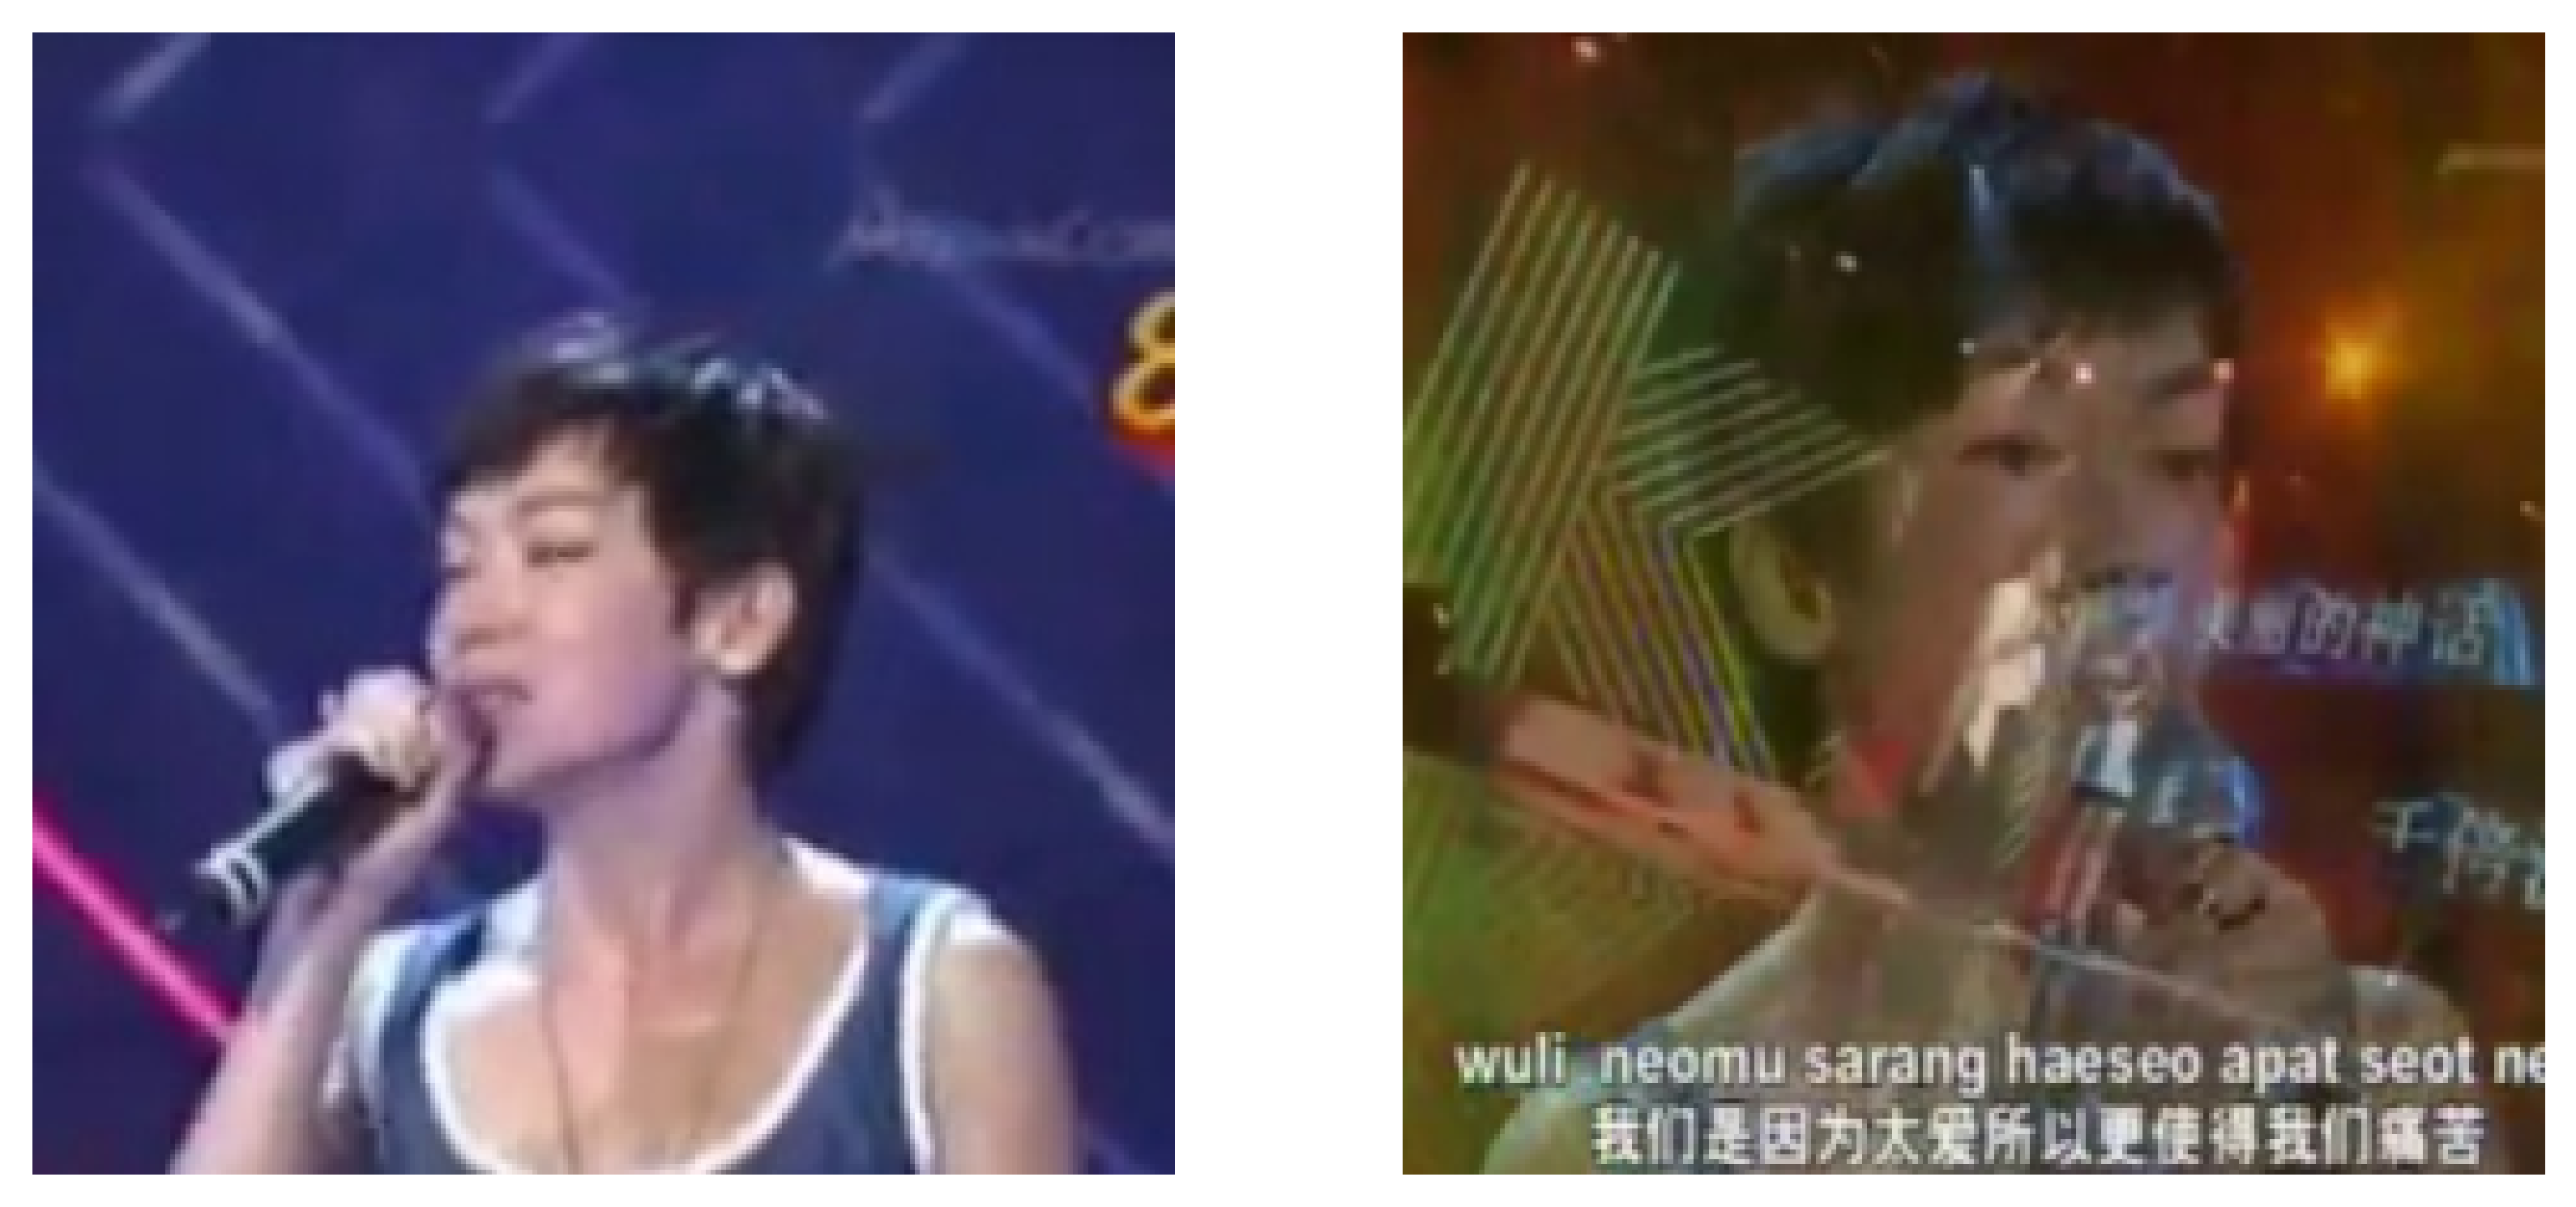

In [62]:
imshow(np.array(img1),np.array(img2))

In [68]:
    # For individual images
wrongIndices=[]
prediction = []
conceptScores1 = None
concepotScores2 = None 
for index in range(0,6000):
 #print(index)   
 img1 = torch.tensor(a[index])
 img2 = torch.tensor(b[index])

 images = torch.stack((img1,img2),dim=0).to(device)
 images = images.to(torch.float16)
 embeddings = model.encode_image(images)

 ratio = 0.1
 embeddingsFC = fcImage(embeddings)
 embeddings = ratio * embeddingsFC + (1 - ratio) * embeddings

 textFeaturesTemp = textFeatures.unsqueeze(1)
 #print(textFeaturesTemp.shape)
 conceptScores = torch.nn.functional.cosine_similarity(textFeaturesTemp,embeddings,dim=-1)
 conceptScores = conceptScores.T


 csNoSM = copy.deepcopy(conceptScores.detach())
 if(conceptScores1==None):
       conceptScores1 =   csNoSM[0].unsqueeze(dim=0)
       conceptScores2 =   csNoSM[1].unsqueeze(dim=0)
 else:
      conceptScores1 = torch.cat((conceptScores1,csNoSM[0].unsqueeze(dim=0)),dim=0)
      conceptScores2 = torch.cat((conceptScores2,csNoSM[1].unsqueeze(dim=0)),dim=0)                         
 print(conceptScores1.shape)   
 indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")
 subtensors = []
 for i in range(len(indices) - 1):
                    start_idx = indices[i]
                    end_idx = indices[i + 1]
                    subtensor = conceptScores[:,start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

                    subtensors.append(subtensor)

 last_start_idx = indices[-1]
 last_subtensor = conceptScores[:,last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
 subtensors.append(last_subtensor)

 conceptScores = torch.cat([torch.nn.functional.softmax(100*subtensor, dim=-1) for subtensor in subtensors], dim=-1)

    #print(conceptScores.shape)

 output = fc(conceptScores)

 norms = torch.norm(output, 2, 1, True)    
   
 
 output = torch.div(output, norms)

 best_threshold = 1.443
 embeddings1 = output[0].cpu().detach().numpy()
 embeddings2 = output[1].cpu().detach().numpy()
 diff = np.subtract(embeddings1, embeddings2)
 dist = np.sum(np.square(diff), 0)
 predict_issame = np.less(dist, best_threshold)
 prediction.append(predict_issame)
 if(predict_issame!=calfw_issame[index]):
  wrongIndices.append(index)
  #print(index,age_30_issame[index])      




torch.Size([1, 106])
torch.Size([2, 106])
torch.Size([3, 106])
torch.Size([4, 106])
torch.Size([5, 106])
torch.Size([6, 106])
torch.Size([7, 106])
torch.Size([8, 106])
torch.Size([9, 106])
torch.Size([10, 106])
torch.Size([11, 106])
torch.Size([12, 106])
torch.Size([13, 106])
torch.Size([14, 106])
torch.Size([15, 106])
torch.Size([16, 106])
torch.Size([17, 106])
torch.Size([18, 106])
torch.Size([19, 106])
torch.Size([20, 106])
torch.Size([21, 106])
torch.Size([22, 106])
torch.Size([23, 106])
torch.Size([24, 106])
torch.Size([25, 106])
torch.Size([26, 106])
torch.Size([27, 106])
torch.Size([28, 106])
torch.Size([29, 106])
torch.Size([30, 106])
torch.Size([31, 106])
torch.Size([32, 106])
torch.Size([33, 106])
torch.Size([34, 106])
torch.Size([35, 106])
torch.Size([36, 106])
torch.Size([37, 106])
torch.Size([38, 106])
torch.Size([39, 106])
torch.Size([40, 106])
torch.Size([41, 106])
torch.Size([42, 106])
torch.Size([43, 106])
torch.Size([44, 106])
torch.Size([45, 106])
torch.Size([46, 106

In [69]:
len(wrongIndices)

863

In [12]:


ratio = 0.2

embeddings = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/imageTensorsVal.pt")
labels = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/imageLabelsVal.pt")

  

#embeddingsFC = fcImage(embeddings)



#embeddings = ratio * embeddingsFC + (1 - ratio) * embeddings

print(textFeatures.shape)
textFeaturesTemp = textFeatures.unsqueeze(1)
print(textFeaturesTemp.shape)
conceptScores = torch.nn.functional.cosine_similarity(textFeaturesTemp,embeddings,dim=-1)
conceptScores = conceptScores.T


csNoSM = copy.deepcopy(conceptScores.detach())
      
indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")
subtensors = []
for i in range(len(indices) - 1):
                    start_idx = indices[i]
                    end_idx = indices[i + 1]
                    subtensor = conceptScores[:,start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

                    subtensors.append(subtensor)

last_start_idx = indices[-1]
last_subtensor = conceptScores[:,last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
subtensors.append(last_subtensor)

conceptScores = torch.cat([torch.nn.functional.softmax(100*subtensor, dim=-1) for subtensor in subtensors], dim=-1)

    #print(conceptScores.shape)

#output = fc(conceptScores)
output = conceptScores







torch.Size([104, 768])
torch.Size([104, 1, 768])


In [13]:
all_output_tensor = output.detach()
all_target_tensor = labels
all_dataname_tensor  = torch.load("/home/csgrad/byalavar/XAI/AdaFace/scripts/dataNameVal.pt")

In [12]:
all_dataname_tensor

tensor([0, 0, 0,  ..., 4, 4, 4], device='cuda:0')

In [14]:


dataname_to_idx = {"agedb_30": 0,"cfp_fp": 1, "lfw": 2, "cplfw": 3, "calfw": 4}
idx_to_dataname = {val: key for key, val in dataname_to_idx.items()}
val_logs = {}

In [15]:
def calculate_accuracy(threshold, dist, actual_issame,saveWrong=False):
    predict_issame = np.less(dist, threshold)
    if(saveWrong):
     print(predict_issame.shape)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, pca=0):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    best_thresholds = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)
    # print('pca', pca)
    dist = None

   
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    #print("Dist: ",dist.shape)
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # print('train_set', train_set)
        #print('test_set', test_set)


        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = calculate_accuracy(threshold,
                                                                                                 dist[test_set],
                                                                                                 actual_issame[
                                                                                                     test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set],
                                                      actual_issame[test_set],saveWrong=False)

    tpr = np.mean(tprs, 0)
    fpr = np.mean(fprs, 0)
    return tpr, fpr, accuracy, best_thresholds




def evaluate(embeddings, actual_issame, nrof_folds=10, pca=0):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, best_thresholds = calculate_roc(thresholds, embeddings1, embeddings2,
                                       np.asarray(actual_issame), nrof_folds=nrof_folds, pca=pca)
    return tpr, fpr, accuracy, best_thresholds


wrongLabels = {}

for dataname_idx in all_dataname_tensor.unique():
        # if(dataname_idx.item()==3):
        #     print("3")
            dataname = idx_to_dataname[dataname_idx.item()]
            # per dataset evaluation
            embeddings = all_output_tensor[all_dataname_tensor == dataname_idx].to('cpu').numpy()
            labels = all_target_tensor[all_dataname_tensor == dataname_idx].to('cpu').numpy()
            issame = labels[0::2]
            #print("test1:",embeddings.shape,issame.shape)
           

            tpr, fpr, accuracy, best_thresholds = evaluate(embeddings, issame, nrof_folds=10)
            acc, best_threshold = accuracy.mean(), best_thresholds.mean()


            #for i in range(0,predict_issame.shape[0]):

            num_val_samples = len(embeddings)
            val_logs[f'{dataname}_val_acc'] = acc
            val_logs[f'{dataname}_best_threshold'] = best_threshold
            val_logs[f'{dataname}_num_val_samples'] = num_val_samples

val_logs['val_acc'] = np.mean([
            val_logs[f'{dataname}_val_acc'] for dataname in dataname_to_idx.keys() if f'{dataname}_val_acc' in val_logs
        ])

        #print("Validation Accuracy:", )
print("Validation Performance: ",val_logs['val_acc'])


Validation Performance:  0.7179380952380953


In [23]:
issame.shape

(6000,)

In [51]:
embeddings1 = embeddings[0::2]
embeddings2 = embeddings[1::2]
conceptScores1 = csNoSM[0::2]
conceptScores2 = csNoSM[1::2]
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(np.square(diff), 1)
predict_issame = np.less(dist, best_threshold)
print(predict_issame.shape)
wrongLabels = []
for i in range(0,predict_issame.shape[0]):
    if(issame[i]!=predict_issame[i]):
        wrongLabels.append(i)



(6000,)


In [70]:
import copy

def groupSm(conceptScores):
    indices = torch.load("/home/csgrad/byalavar/XAI/AdaFace/gl.pt")
    subtensors = []
    for i in range(len(indices) - 1):
                start_idx = indices[i]
                end_idx = indices[i + 1]
                subtensor = conceptScores[start_idx:end_idx]#.clone()  # Clone the subtensor to detach it from computation graph

                subtensors.append(subtensor)

    last_start_idx = indices[-1]
    last_subtensor = conceptScores[last_start_idx:]#.clone()  # Clone the subtensor to detach it from computation graph
    subtensors.append(last_subtensor)

    conceptScores = torch.cat([torch.nn.functional.softmax(100*subtensor, dim=-1) for subtensor in subtensors], dim=-1)
    return conceptScores

def generateCF(cScore1,cScore2,fc,identDecision,threshold,count=0): 
        #super(cf,self).__init__()

        cScoreOg1 = copy.deepcopy(cScore1.detach())
        cScoreOg2 = copy.deepcopy(cScore2.detach())

        cScore1 = copy.deepcopy(cScore1.detach())
        cScore2 = copy.deepcopy(cScore2.detach())

        # out1 = fc(cScore1)
        # out2 = fc(cScore2)


        # diff = torch.subtract(out1, out2)
        # dist = torch.sum(torch.square(diff), dim=0)

        # ident = False

        # if(dist<threshold):
        #      ident = True
             

        conceptScores1 = nn.Parameter(cScore1,requires_grad=False)
        conceptScores2 = nn.Parameter(cScore2,requires_grad=True)

        for i in fc.parameters():
            i.requires_grad = False
        
        optimizer = torch.optim.SGD([conceptScores1,conceptScores2],lr=0.01,momentum=0.9)

        lossFunc = nn.MSELoss()

        for i in range(0,1000):
            optimizer.zero_grad()
    

            output1 = fc(groupSm(conceptScores1))
            output2 = fc(groupSm(conceptScores2))

            
            # output1 = groupSm(conceptScores1)
            # output2 = groupSm(conceptScores2)

            diff = torch.subtract(output1, output2)
            dist = torch.sum(torch.square(diff), dim=0)
            #print("Dist: ",dist)
            if(identDecision):
                if(dist>threshold):
                    #print(groupSm(conceptScores1),groupSm(conceptScores2))
                    count = count + 1
                    break
            
            else:
                if(dist<=threshold):
                    #print(groupSm(conceptScores1),groupSm(conceptScores2))
                    count = count + 1
                    break



            if(identDecision):
             loss = -lossFunc(output1,output2) + 1*(conceptScores1-cScore1).norm(p=1) \
                    + 1*(conceptScores2-cScore2).norm(p=1) + 0.1*(conceptScores1-cScore1).norm(p=2) \
                    + 0.1*(conceptScores2-cScore2).norm(p=2)
            
            else:
                loss = lossFunc(output1,output2) + 1*(conceptScores1-cScore1).norm(p=1) \
                    + 1*(conceptScores2-cScore2).norm(p=1) + 0.1*(conceptScores1-cScore1).norm(p=2) \
                    + 0.1*(conceptScores2-cScore2).norm(p=2)

            
            loss.backward()
            optimizer.step()
        
        return getCFConcepts(torch.stack((groupSm(cScoreOg1),groupSm(cScoreOg2))),torch.stack((groupSm(conceptScores1),groupSm(conceptScores2))))

            
         

        #print("Updated Label:",torch.argmax(output,dim=1))
      
        
def getCFConcepts(ogConcepts, cfConcepts,single=True):

    delta = 0.05

    abs_diff = torch.abs(ogConcepts - cfConcepts)
    #print(abs_diff)
    indices = torch.nonzero(abs_diff > delta)
    #print(indices)
    #print("Indices where absolute difference exceeds delta:")
    #print("First Image:")
    firstImageCFs = []
    secondImageCFsInc = []
    secondImageCFsDec = []

    for i in range(0,indices.shape[0]):
        if(indices[i][0]==0):
         print("here") 
         firstImageCFs.append(concepts[indices[i][1]])#,ogConcepts[0][indices[i][1]],cfConcepts[0][indices[i][1]]))
    #print("Second Image:")
    for i in range(0,indices.shape[0]):
        if(indices[i][0]==1):
         #if(single):
          #print(concepts[indices[i][1]],ogConcepts[1][indices[i][1]].item(),cfConcepts[1][indices[i][1]].item())
         if(ogConcepts[1][indices[i][1]].item()-cfConcepts[1][indices[i][1]].item()>0): 
          secondImageCFsDec.append(concepts[indices[i][1]])#,ogConcepts[1][indices[i][1]],cfConcepts[1][indices[i][1]])
         else:
          secondImageCFsInc.append(concepts[indices[i][1]]) 
    #print("len:",len(firstImageCFs))
    #firstImageCFs = firstImageCFs.extend(secondImageCFs) 
    return secondImageCFsInc,secondImageCFsDec    


In [162]:
conceptScores1 = csNoSM[0]
conceptScores2 = csNoSM[1]

best_threshold = 1.32
embeddings1 = output[0].cpu().detach().numpy()
embeddings2 = output[1].cpu().detach().numpy()
diff = np.subtract(embeddings1, embeddings2)
dist = np.sum(np.square(diff), 0)
predict_issame = np.less(dist, best_threshold)
print(predict_issame)

False


In [164]:
print(generateCF(conceptScores1,conceptScores2,fc,predict_issame,best_threshold))

Forehead width: Normal 0.26711902022361755 0.320960134267807
Forehead width: Narrow 0.5282680988311768 0.46829116344451904
Dimple is present in the Right Cheek 0.2748121917247772 0.32795998454093933
No Dimple is present in the Right Cheek 0.7251877784729004 0.6720400452613831
Nasal base: Narrow 0.5482290387153625 0.48460352420806885
Nasal base: Wide 0.4517710208892822 0.5153965353965759
Skin marks is Present 0.36680081486701965 0.4262884855270386
Skin marks is Absent 0.6331992149353027 0.5737115144729614
['Forehead width: Normal', 'Forehead width: Narrow', 'Dimple is present in the Right Cheek', 'No Dimple is present in the Right Cheek', 'Nasal base: Narrow', 'Nasal base: Wide', 'Skin marks is Present', 'Skin marks is Absent']


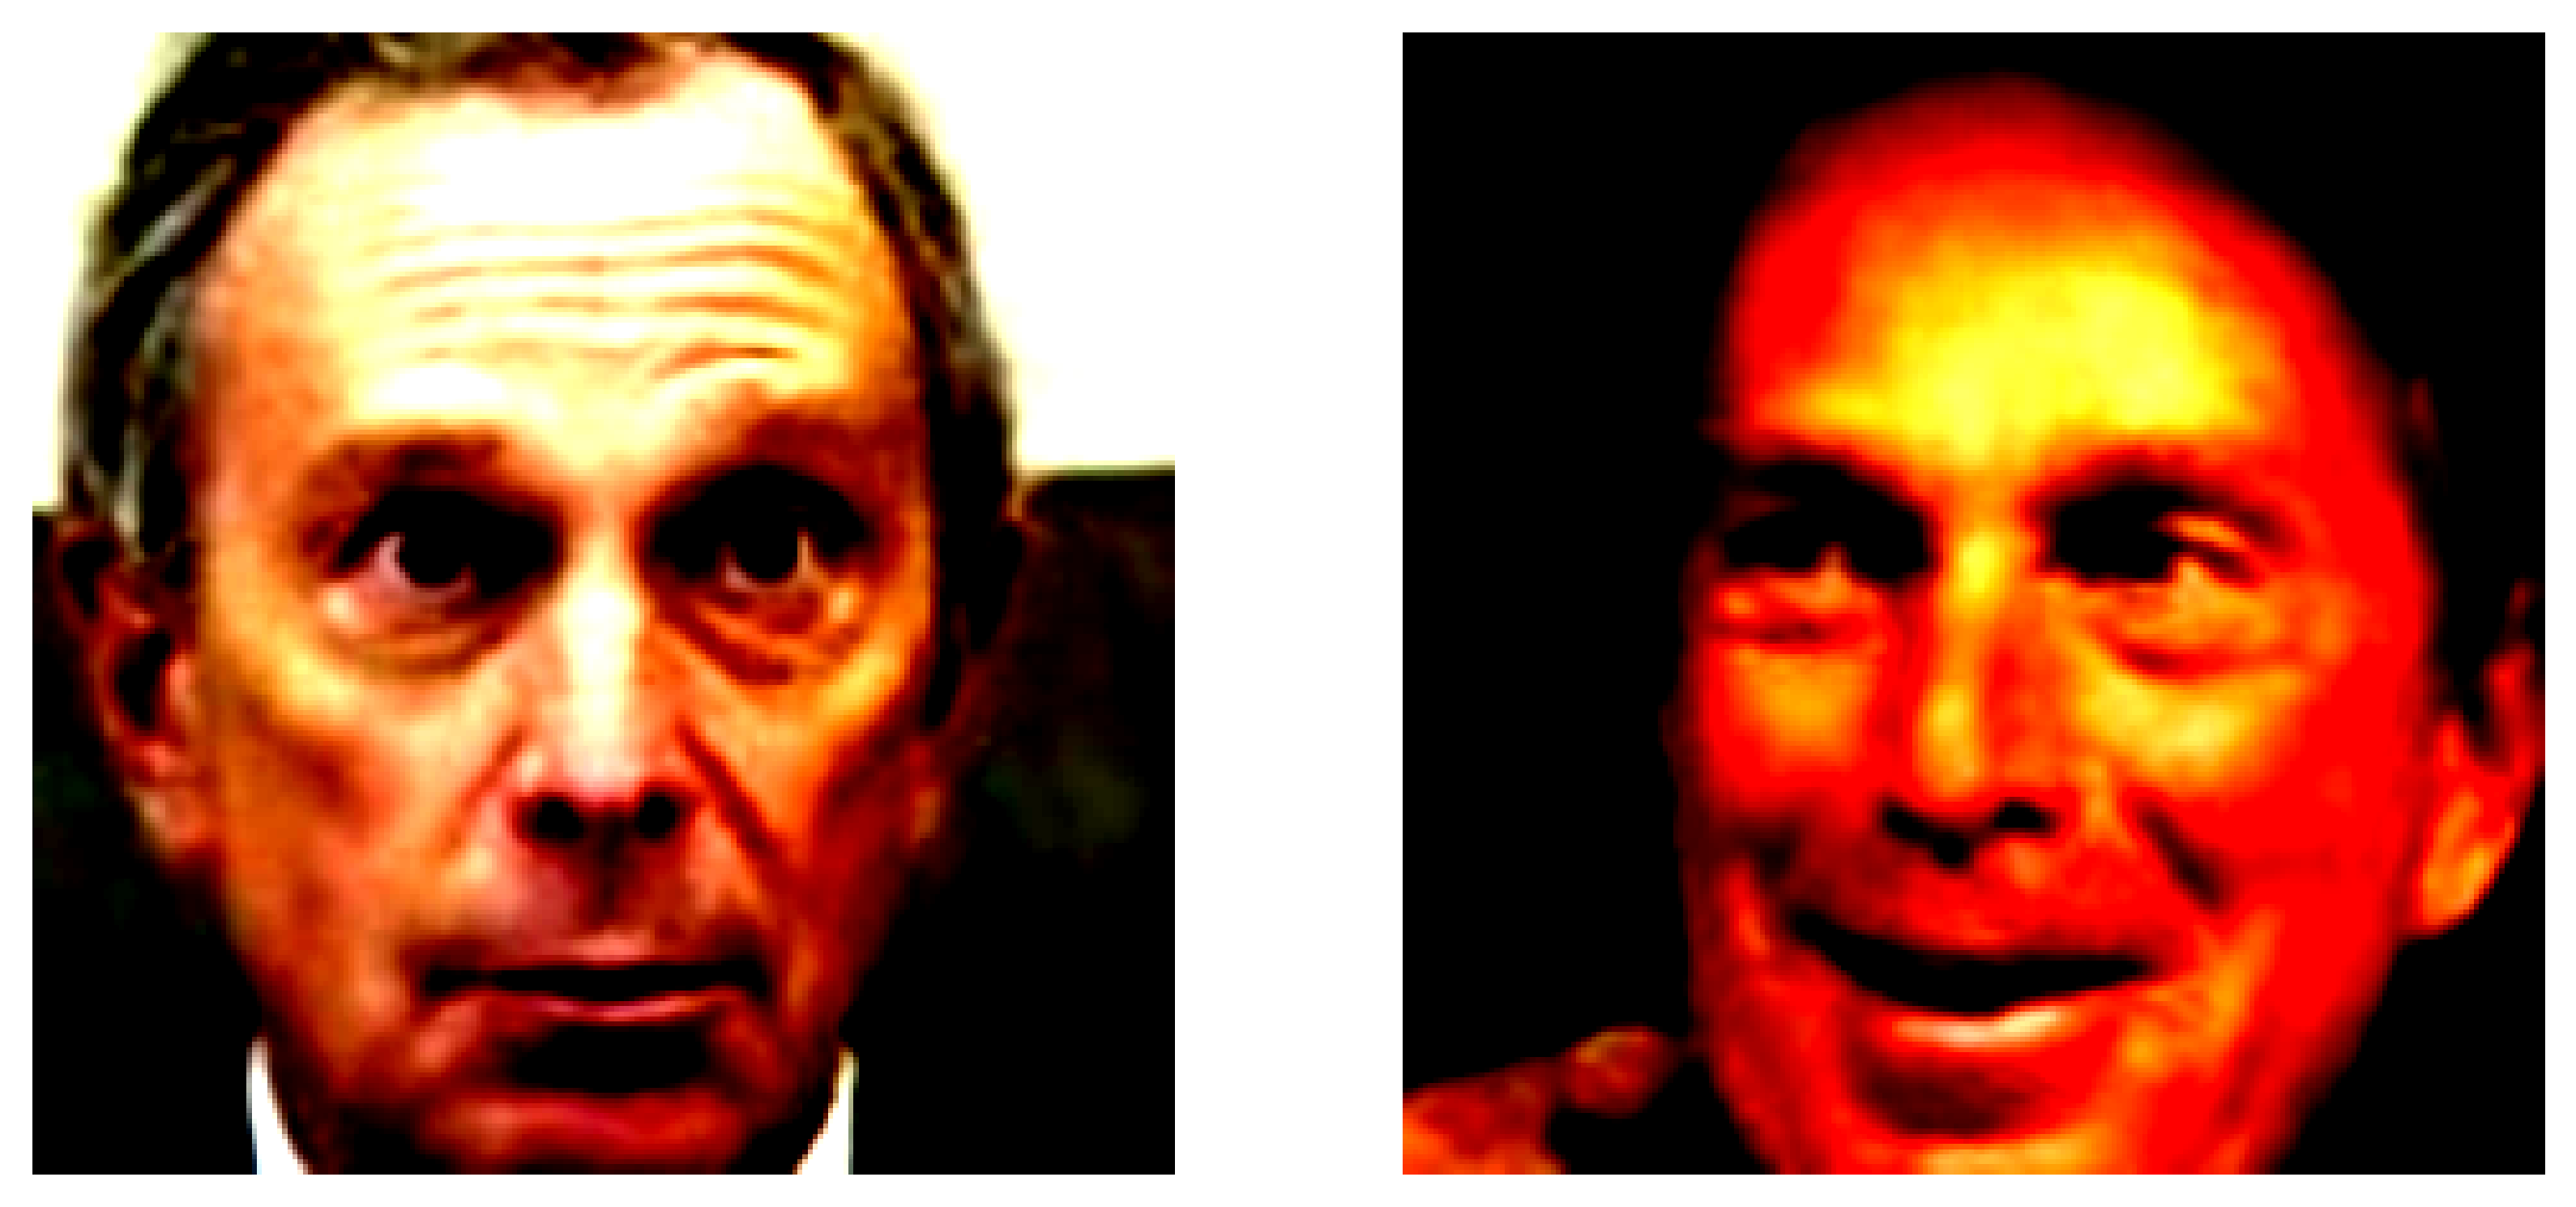

In [165]:
imshow(np.array(img1),np.array(img2))

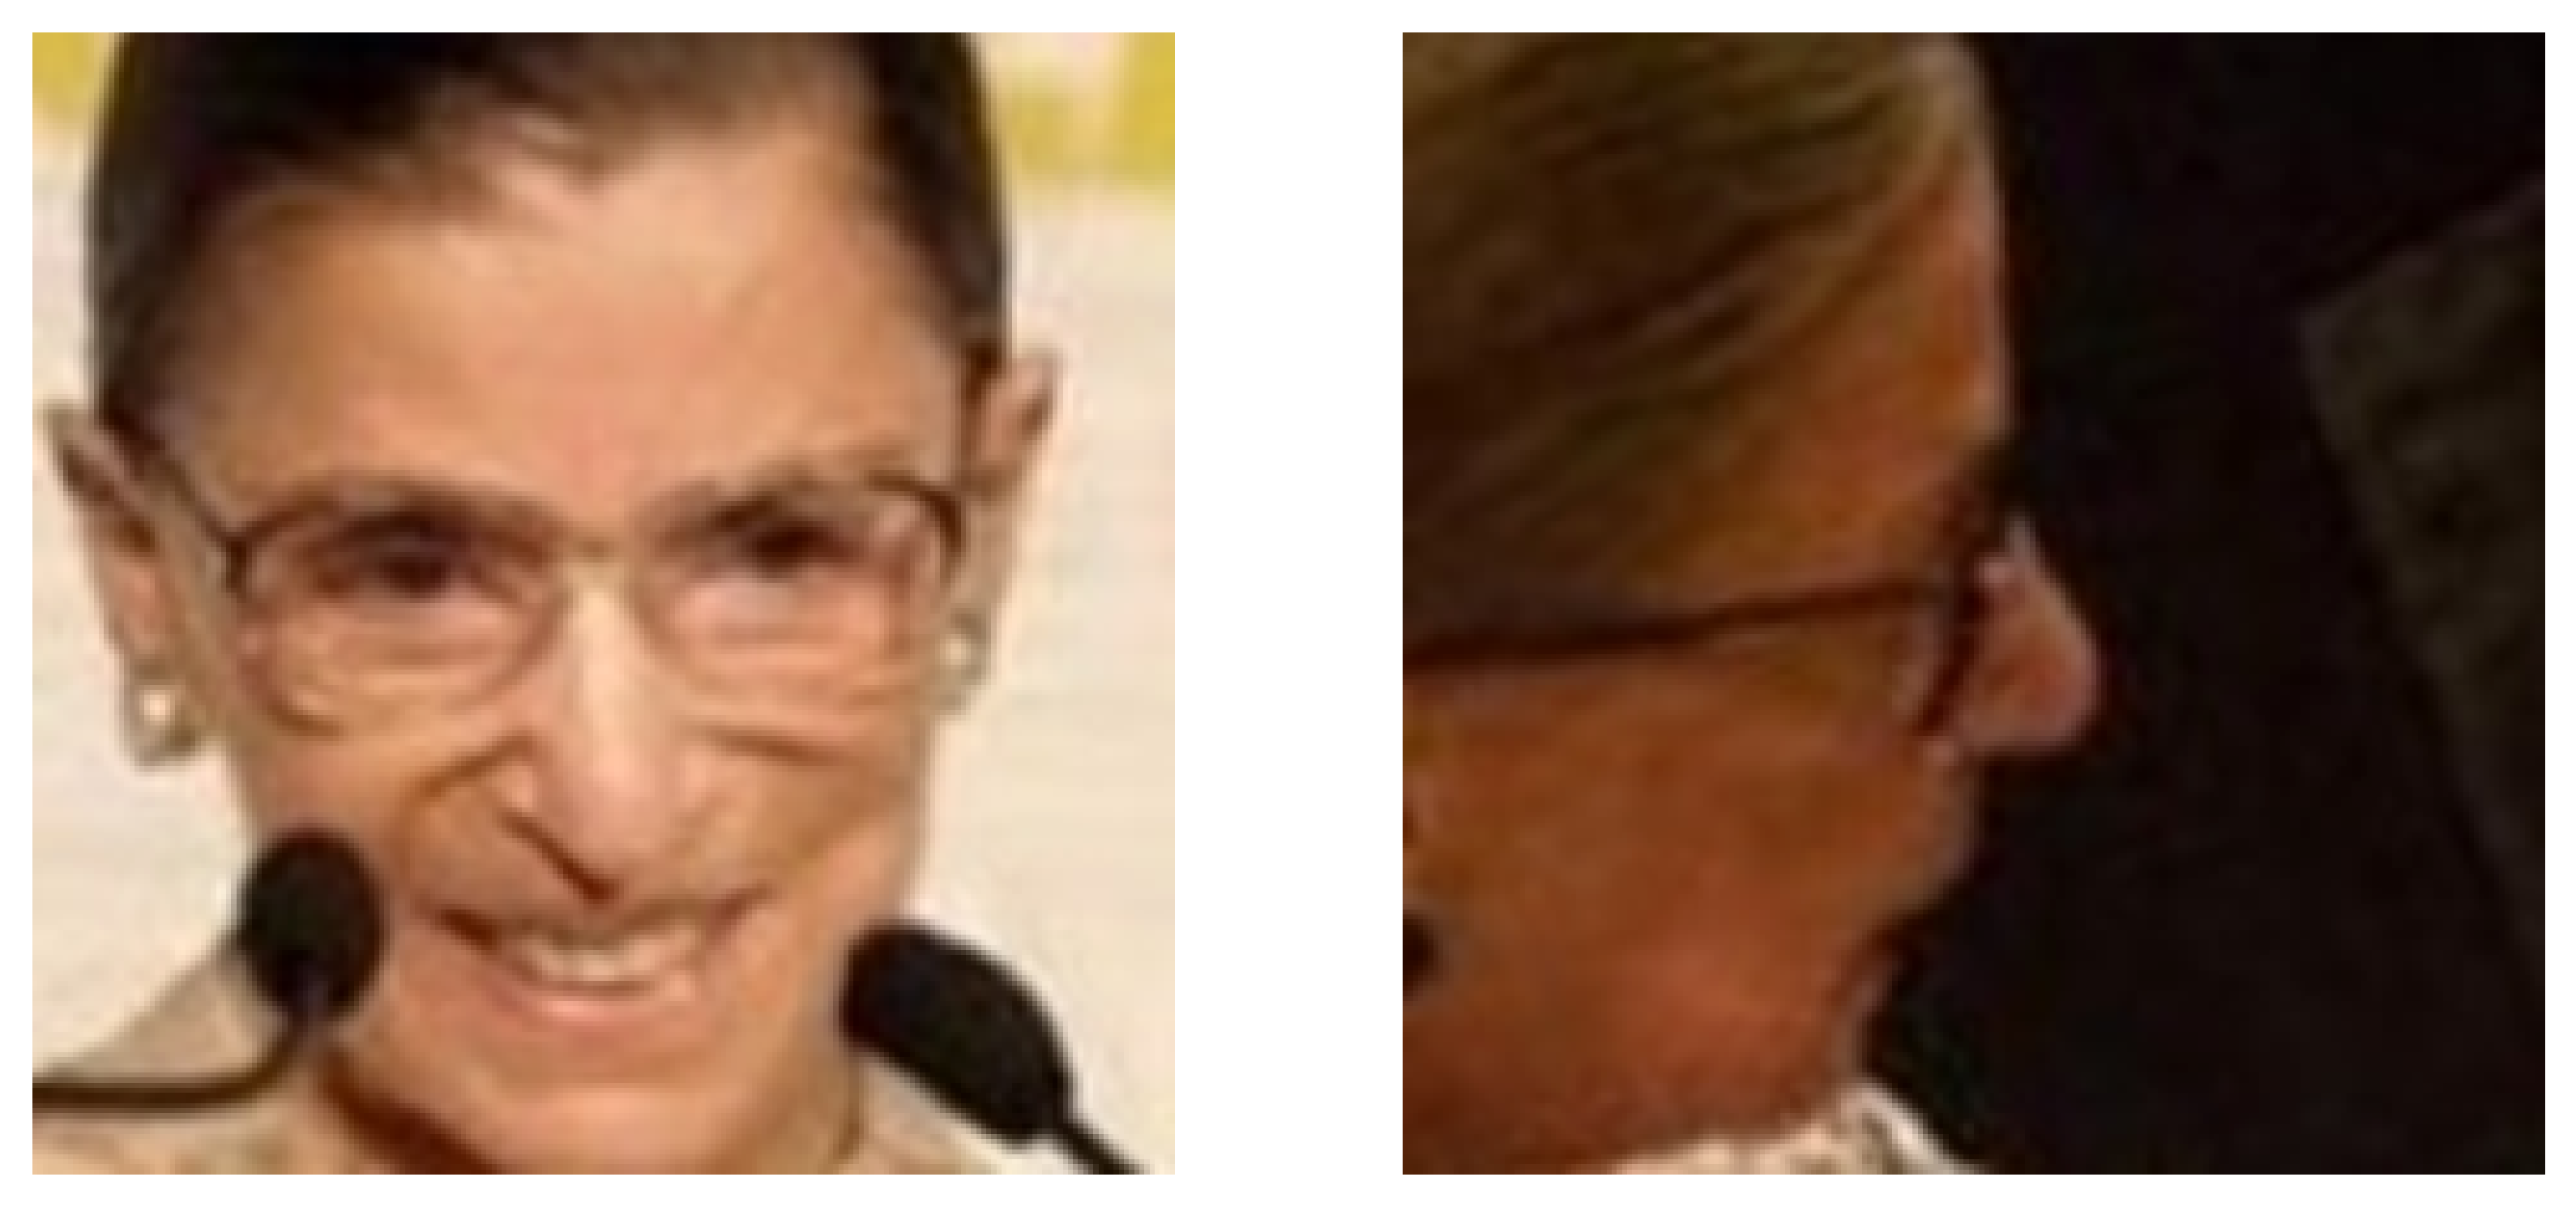

1


In [226]:
imshow(np.array(a[index]),np.array(b[index]))
print(cplfw_issame[index])

In [71]:
count = 0
breakCount = 0
cfConceptsInc = []
cfConceptsDec = []
allIndices = []
best_threshold = 1.487  
for i in wrongIndices:

    print(i)
    temp1,temp2 = generateCF(conceptScores1[i],conceptScores2[i],fc,prediction[i],best_threshold)
    if(len(temp1)==0):
        temp1=[""]
    else:
        temp1 = [temp1]
    cfConceptsInc.extend(temp1)

    if(len(temp2)==0):
        temp2=[""]
    else:
        temp2 = [temp2]
    cfConceptsDec.extend(temp2)
   

    #break

#print("Average: ",count/len(wrongLabels))


0
3
5
6
7
9
10
17
18
20
25
30
33
34
39
46
47
51
59
60
61
65
84
101
110
123
147
182
206
235
252
263
299
306
315
321
336
344
345
359
365
366
372
379
383
384
390
395
398
410
417
425
427
435
436
440
455
460
464
470
483
491
492
494
495
498
500
506
514
515
518
519
522
536
550
554
556
570
572
585
590
592
593
594
599
600
617
618
629
630
644
649
656
672
682
702
718
719
721
781
801
802
811
816
827
832
839
843
845
853
860
862
869
881
883
905
919
927
940
955
956
969
971
990
991
1006
1008
1012
1013
1016
1018
1026
1029
1049
1055
1068
1079
1090
1092
1093
1097
1108
1111
1116
1124
1125
1126
1127
1129
1132
1134
1138
1140
1164
1166
1173
1174
1187
1193
1195
1199
1201
1202
1208
1218
1236
1237
1256
1261
1262
1285
1295
1315
1323
1343
1345
1347
1355
1366
1371
1384
1405
1433
1447
1448
1452
1455
1478
1480
1493
1496
1503
1506
1513
1514
1530
1534
1539
1546
1549
1556
1565
1571
1577
1578
1586
1591
1611
1616
1630
1632
1635
1643
1668
1671
1672
1673
1676
1678
1680
1682
1689
1690
1693
1694
1696
1698
1700
1702
1703
1706

In [73]:
from collections import Counter
def count_sorted_by_occurrences(lst):
    # Flatten the list of lists into a single list
    #print(lst)
    flattened_list = [item for sublist in lst for item in sublist]
    #print(flattened_list)
    # Count occurrences of each value in the flattened list
    counts = Counter(flattened_list)
    
    # Sort the counts by occurrences (in descending order)
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_counts



# Get count of each value sorted by most occurrences
count_sorted = count_sorted_by_occurrences(cfConceptsInc)
#print(count_sorted)
# Print the result
for value, count in count_sorted:
    print(f"{value}: {count}")

Brow ridges are Prominent: 121
Brow ridges are Subtle: 112
Face of a Female: 108
Scars is Absent: 107
Frontal lines (forehead wrinkles) is Present: 104
Nasal base: Narrow: 103
Facial hair on neck, below chin/jawline is Absent: 101
Piercing is Absent: 99
Mouth abnormalities: Present: 99
Skin marks is Absent: 96
Skin marks is Present: 95
Face of a middle aged person: 95
Mouth abnormalities: Absent: 92
Right Cheekbone is not prominent: 92
Makeup is Present: 90
Frontal lines (forehead wrinkles) is Absent: 89
Left Cheekbone is not prominent: 89
Laryngeal prominence (Adam's apple) is Prominent: 88
Right Cheekbone is prominent: 87
Laryngeal prominence (Adam's apple) is Subtle: 83
Face of a Male: 83
Makeup is Absent: 81
Face of a Young Person: 79
Dimple is present in the Right Cheek: 75
Nasal base: Wide: 73
Facial hair on neck, below chin/jawline is Present: 68
Scars is Present: 68
Left Cheekbone is prominent: 65
Tattoo is Absent: 64
Hair Color: Blonde: 54
Dimple is present in the Left Cheek: 

In [75]:
searchString = "Brow ridges are Prominent"

indices = [index for index, sublist in enumerate(cfConceptsInc) if searchString in sublist]

print(indices)

[8, 10, 33, 34, 35, 43, 49, 52, 59, 65, 70, 78, 79, 82, 122, 131, 136, 148, 156, 162, 163, 192, 193, 197, 198, 205, 206, 207, 208, 211, 213, 216, 217, 219, 220, 223, 226, 227, 228, 230, 241, 247, 252, 259, 279, 302, 304, 305, 308, 322, 344, 349, 350, 389, 395, 398, 400, 405, 408, 413, 415, 422, 425, 426, 428, 429, 431, 467, 473, 485, 486, 494, 501, 502, 504, 513, 519, 523, 527, 541, 576, 579, 582, 586, 592, 594, 597, 603, 627, 634, 638, 643, 648, 653, 659, 662, 668, 672, 676, 677, 686, 687, 691, 733, 734, 737, 742, 747, 764, 765, 769, 811, 815, 822, 824, 825, 835, 836, 839, 847, 848]


In [43]:
a.shape

(6000, 3, 224, 224)

In [97]:

imgs1 = imgs[0::2]
imgs2 = imgs[1::2]

def imshow(img1,img2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Create a figure with two subplots
    
    # Plot the first image
    img_array1 = img1[[0, 1, 2], :, :].transpose((1, 2, 0))
    print(img_array1.shape)
    axes[0].imshow(img_array1)
    axes[0].axis('off')  # Turn off axis
    
    # Plot the second image
    img_array2 = img2[[0, 1, 2], :, :].transpose((1, 2, 0))
    axes[1].imshow(img_array2)
    axes[1].axis('off')  # Turn off axis
    
    plt.show()

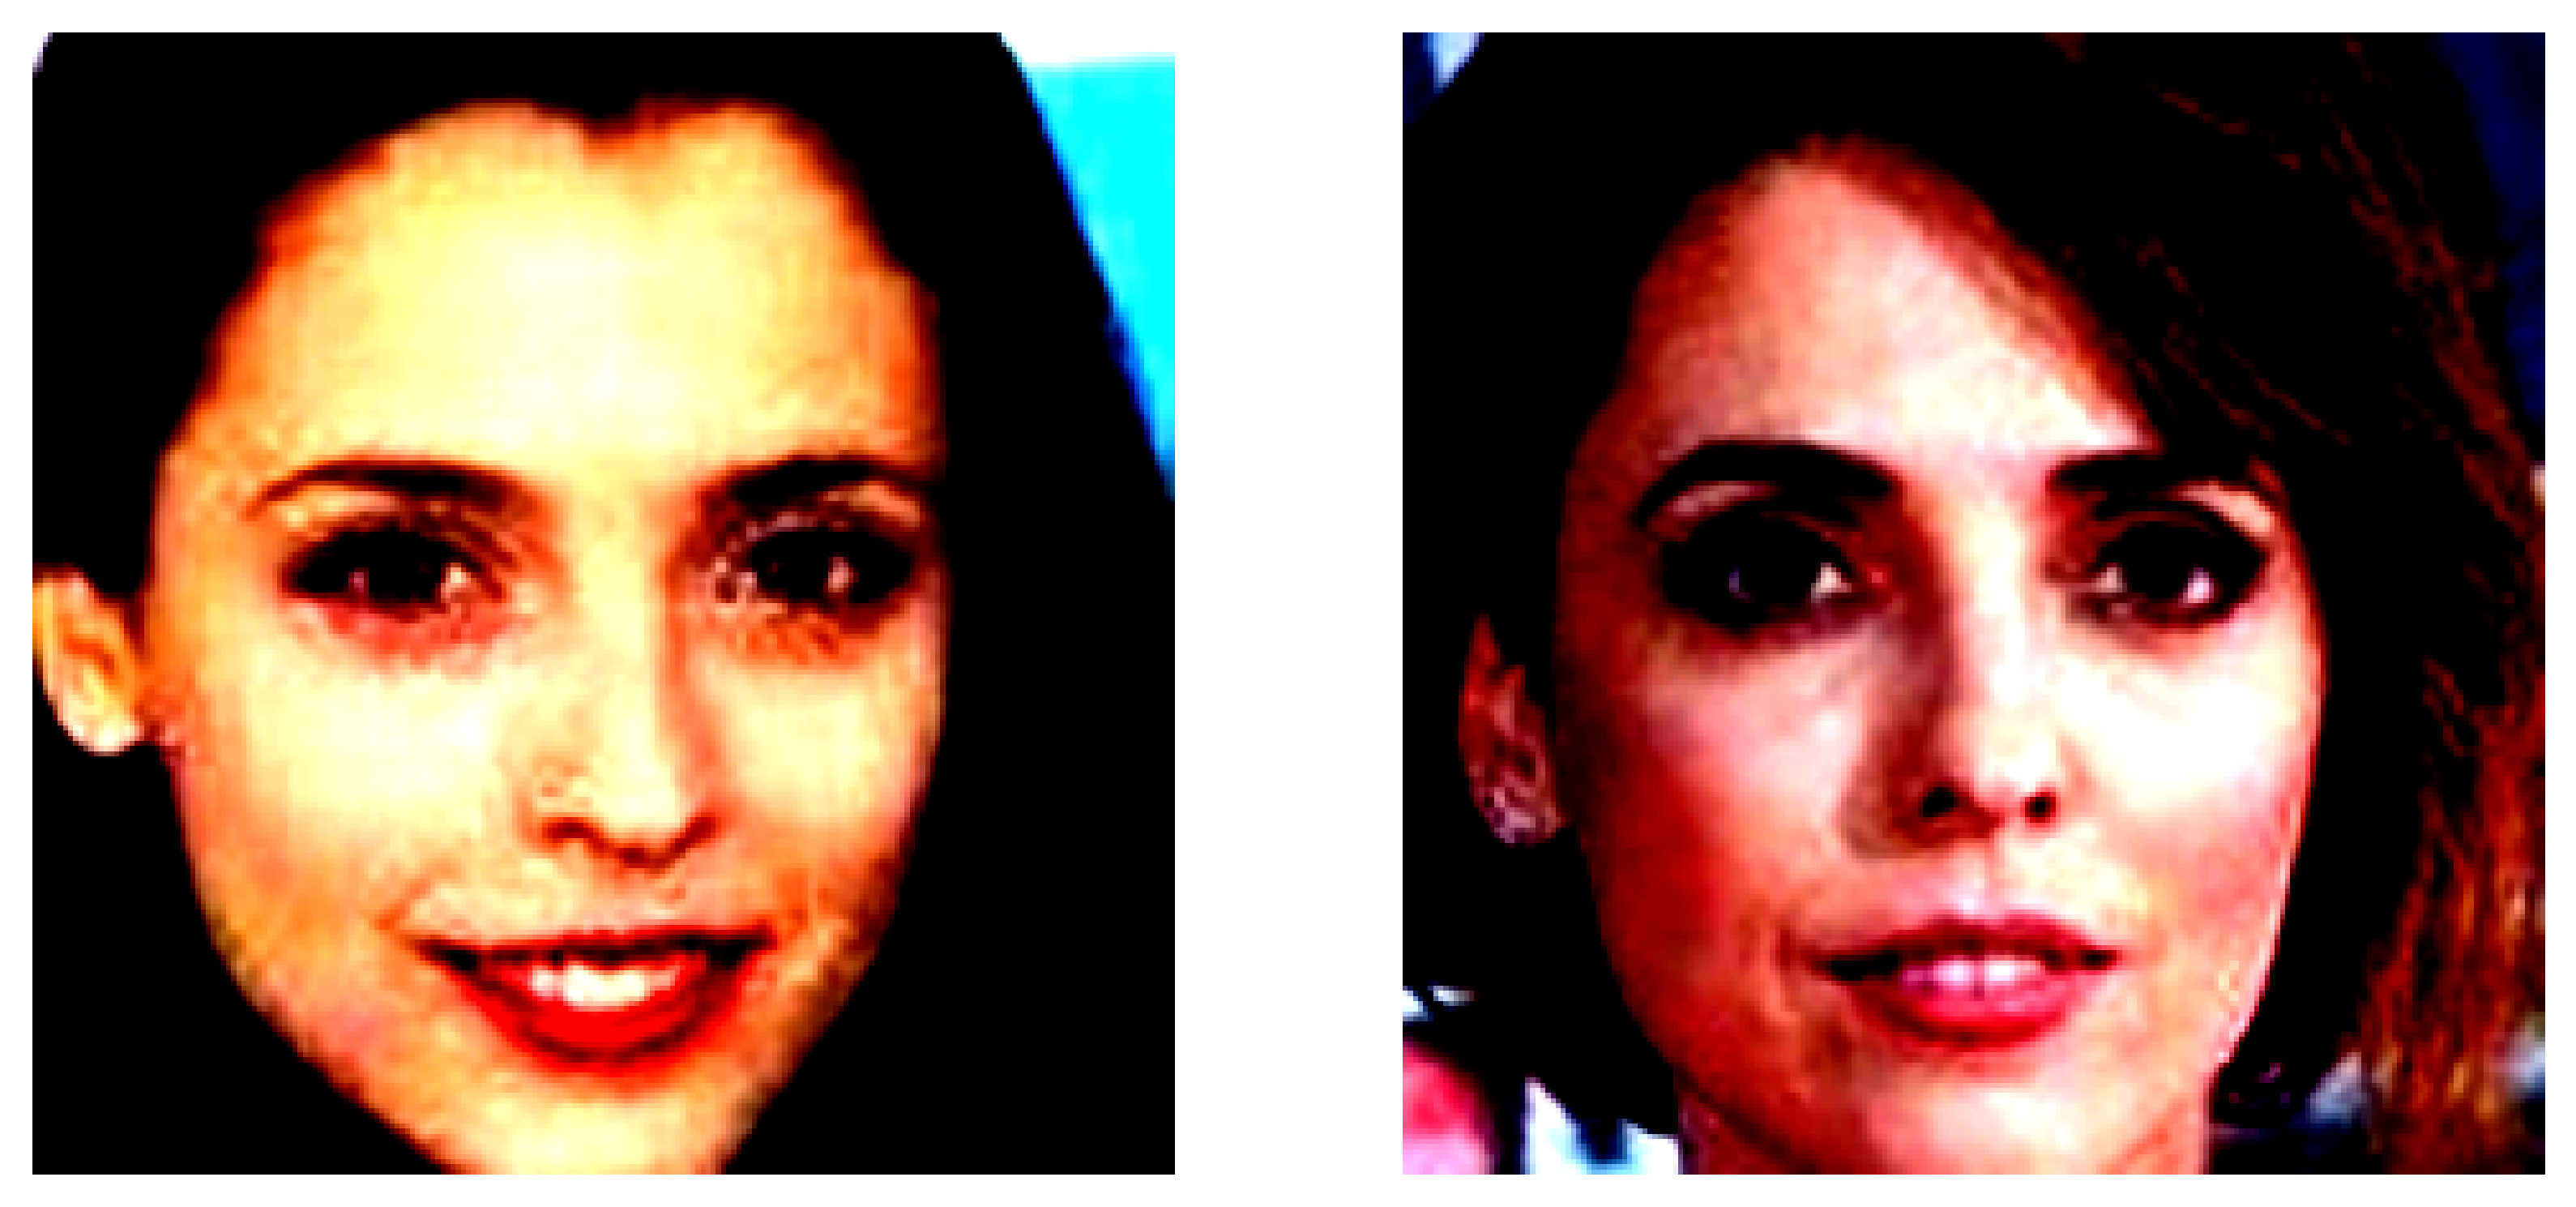

In [76]:
index = 41
imshow(np.array(a[indices[index]]),np.array(b[indices[index]]))
print()

In [36]:
count

0

In [2]:
!pip install SciencePlots
#!pip install latex

/usr/bin/bash: /home/csgrad/byalavar/miniconda3/envs/train/lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)


In [3]:

import matplotlib.pyplot as plt
import scienceplots
import matplotlib
Features = ["Identity", "Age" , "Gender" , "Ethnicity"]
compression = [8, 16, 32, 64, 128, 256]
id = [58.12, 81.18, 88, 90.62, 91.25, 91.06]
age = [66, 71.5,73.5, 78.4, 78.13, 77.68]
gender = [70.75, 84.81,91.56, 95.81, 95.87, 97.06]
eth = [82.93, 89.25, 94.69, 93.5, 96.5, 95.31]
plt.rcParams['font.weight'] = 'bold'
with plt.style.context(['ieee', 'science']):
  # Plot id vs Age with labels
  plt.figure(figsize=(8, 6))
  plt.scatter(compression, id)
  plt.plot(compression, id, label="Identity")
  plt.scatter(compression, age)
  plt.plot(compression, age, label="Age")
  plt.scatter(compression, gender)
  plt.plot(compression, gender, label="Gender")
  plt.scatter(compression, eth)
  plt.plot(compression, eth, label="Ethnicity")
  # plt.plot(age_leakage, id, label=protection)
  plt.xlabel('Compression Dimension', fontweight='bold')
  plt.ylabel('Classification Accuracy', fontweight='bold')
  plt.title('Classification Accuracy vs Compression Dimension using MRL', fontweight='bold')
  # plt.xlim(0, 300)
  plt.ylim(50, 100)
  plt.xscale('log', base=2)
  plt.xticks(compression, compression)
  plt.legend()
  plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 4800x3600 with 1 Axes>

In [4]:
!apt install cm-super

/usr/bin/bash: /home/csgrad/byalavar/miniconda3/envs/train/lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
